<a href="https://colab.research.google.com/github/zyrtecdos/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=64.19533883426385, mobile=True), User(purchased=False, time_on_site=164.29663620192443, mobile=True), User(purchased=False, time_on_site=206.08417155151415, mobile=False), User(purchased=False, time_on_site=94.0273696304793, mobile=True), User(purchased=False, time_on_site=488.6337137289614, mobile=False), User(purchased=True, time_on_site=201.73567504355674, mobile=True), User(purchased=False, time_on_site=202.87287614510967, mobile=True), User(purchased=False, time_on_site=127.06493199820261, mobile=True), User(purchased=False, time_on_site=245.5798992068194, mobile=True), User(purchased=False, time_on_site=140.19649110148248, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,64.195339,True
1,False,164.296636,True
2,False,206.084172,False
3,False,94.027370,True
4,False,488.633714,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,6.470284202040581,6.503721657920575,7.200045932560037,7.248628162536775,7.289649254119713,7.448438929909733,7.786674483275108,7.932427283211361,7.947573403547031,8.399003847448505,...,577.4500515330384,587.9468737176468,589.27812037756,590.5698762925205,590.7393123237085,591.9811390758905,593.7200113856915,594.1573541408471,595.9909589338343,596.6514106001316
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,0,1,0,1,...,1,1,1,1,1,1,1,1,0,1
True,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.88, 124.507]","(124.507, 242.543]","(242.543, 360.579]","(360.579, 478.615]","(478.615, 596.651]"
purchased,,,,,
False,289,284,151,50,59
True,68,59,27,5,8


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.88, 124.507]","(124.507, 242.543]","(242.543, 360.579]","(360.579, 478.615]","(478.615, 596.651]"
purchased,,,,,
False,0.809524,0.827988,0.848315,0.909091,0.880597
True,0.190476,0.172012,0.151685,0.090909,0.119403


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.916,0.805333
True,0.084,0.194667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

a= time_bins
b = user_data['purchased']
c = user_data['mobile']


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(5.88, 124.507]     0.103641  0.705882  0.005602  0.184874
(124.507, 242.543]  0.137026  0.690962  0.011662  0.160350
(242.543, 360.579]  0.202247  0.646067  0.011236  0.140449
(360.579, 478.615]  0.909091  0.000000  0.090909  0.000000
(478.615, 596.651]  0.880597  0.000000  0.119403  0.000000

In [0]:
a= time_bins
b = user_data['purchased']
c = user_data['mobile']


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='columns')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(5.88, 124.507]     0.161572  0.417219  0.095238  0.452055
(124.507, 242.543]  0.205240  0.392384  0.190476  0.376712
(242.543, 360.579]  0.157205  0.190397  0.095238  0.171233
(360.579, 478.615]  0.218341  0.000000  0.238095  0.000000
(478.615, 596.651]  0.257642  0.000000  0.380952  0.000000

In [0]:
a= time_bins
b = user_data['purchased']
c = user_data['mobile']


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='all')

purchased           False         True        
mobile              False  True   False  True 
time_bins                                     
(5.88, 124.507]     0.037  0.252  0.002  0.066
(124.507, 242.543]  0.047  0.237  0.004  0.055
(242.543, 360.579]  0.036  0.115  0.002  0.025
(360.579, 478.615]  0.050  0.000  0.005  0.000
(478.615, 596.651]  0.059  0.000  0.008  0.000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# Load data into dataframe
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/zyrtecdos/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv")
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
# preview the dataset
df.describe(include='all')

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [0]:
df.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


In [0]:
# need to put time, weight, age into a list because they are all continuous variables
time_bins = pd.cut(df['exercise_time'], 5)  # 5 equal-sized bins
age_bins = pd.cut(df['age'], 5)
weight_bins = pd.cut(df['weight'], 5)
# Explore the relationship between age and exercise time by column
pd.crosstab(age_bins, time_bins, normalize='columns')

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",0.187050,0.145570,0.242152,0.317708,0.225131
"(30.4, 42.8]",0.187050,0.174051,0.188341,0.244792,0.298429
"(42.8, 55.2]",0.147482,0.132911,0.174888,0.177083,0.350785
"(55.2, 67.6]",0.165468,0.224684,0.179372,0.213542,0.125654
"(67.6, 80.0]",0.312950,0.322785,0.215247,0.046875,0.000000


In [0]:
# Explore the relationship between age and exercise time by row
pd.crosstab(age_bins, time_bins, normalize='index')

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",0.203125,0.179688,0.210938,0.238281,0.167969
"(30.4, 42.8]",0.205534,0.217391,0.166008,0.185771,0.225296
"(42.8, 55.2]",0.183857,0.188341,0.174888,0.152466,0.300448
"(55.2, 67.6]",0.207207,0.319820,0.180180,0.184685,0.108108
"(67.6, 80.0]",0.353659,0.414634,0.195122,0.036585,0.000000


In [0]:
# Explore the relationship between weight and exercise time
pd.crosstab(weight_bins, time_bins, normalize='columns')

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",0.190647,0.205696,0.318386,0.411458,0.560209
"(129.2, 158.4]",0.158273,0.240506,0.300448,0.385417,0.387435
"(158.4, 187.6]",0.219424,0.294304,0.251121,0.197917,0.052356
"(187.6, 216.8]",0.273381,0.231013,0.130045,0.005208,0.000000
"(216.8, 246.0]",0.158273,0.028481,0.000000,0.000000,0.000000


In [0]:
# Explore the relationship between weight and age time
pd.crosstab(weight_bins, age_bins, normalize='columns')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
"(99.854, 129.2]",0.312500,0.411067,0.349776,0.238739,0.243902
"(129.2, 158.4]",0.335938,0.245059,0.278027,0.319820,0.219512
"(158.4, 187.6]",0.191406,0.193676,0.219731,0.202703,0.268293
"(187.6, 216.8]",0.132812,0.122530,0.116592,0.198198,0.178862
"(216.8, 246.0]",0.027344,0.027668,0.035874,0.040541,0.089431


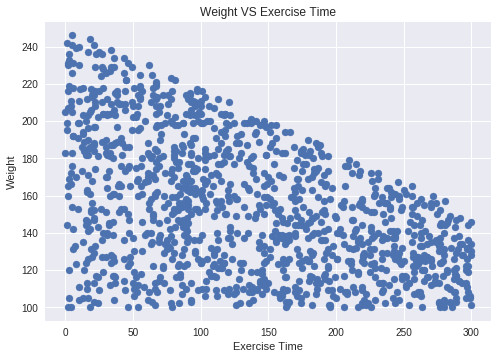

In [0]:
# Graph scatterplot to further explore relationship of weight vs exercise time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Weight VS Exercise Time')
ax.set_xlabel('Exercise Time')
ax.set_ylabel('Weight')
ax.scatter(df['exercise_time'],df['weight'])
plt.show()

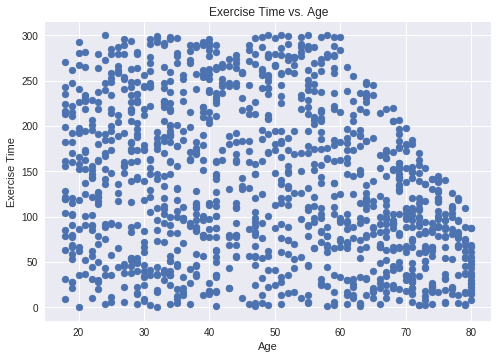

In [0]:
# Graph scatterplot to further explore relationship of exercise time vs age
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Exercise Time vs. Age')
ax.set_xlabel('Age')
ax.set_ylabel('Exercise Time')
ax.scatter(df['age'],df['exercise_time'])
plt.show()

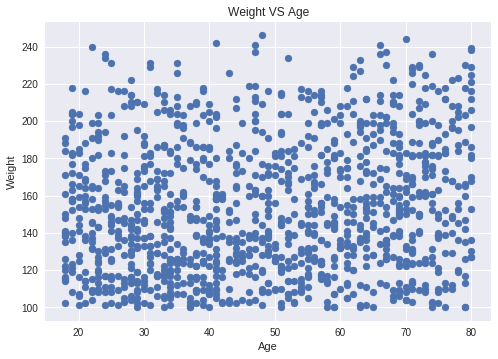

In [0]:
# Graph scatterplot to further explore relationship of weight vs age
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Weight VS Age')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.scatter(df['age'],df['weight'])
plt.show()

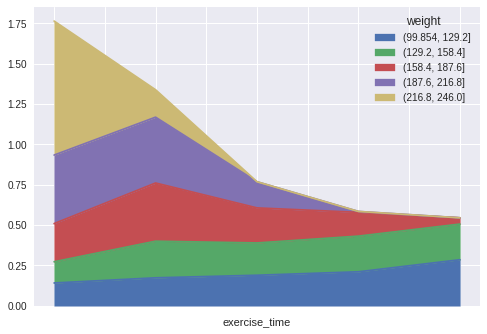

In [0]:
ax=pd.crosstab(time_bins, weight_bins, normalize='columns')
ax.plot.area();

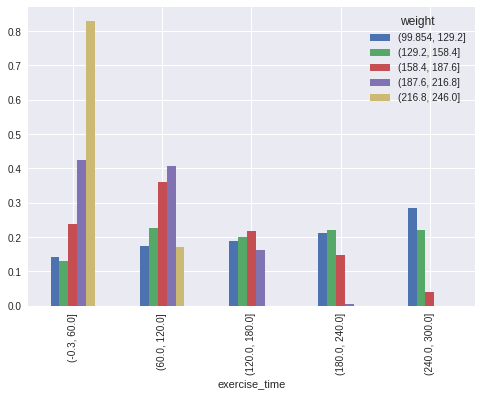

In [0]:
ax.plot.bar();

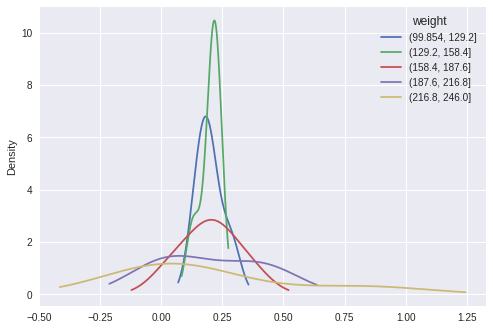

In [0]:
ax.plot.density();

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

Age, time, and weight are continuous variables within an interval.

2.  What are the relationships between the variables?

Exercise time seem to have some correlation with both age and weight.
Age and weight seem to have low correlation with each other.

3.  Which relationships are "real", and which spurious?

Exercise Time Vs Age and Weight vs Exercise Time may have real relationship since there are trend to support their correlations. From reviewing the data table and graph, we can hypothesize that exercise time decrease when you get to a certain age and people with higher exercise time tends to have lower weight. However, there are many other confounding variables (eg. gender, diet, lifestyle choices) that can affect our current hypothesis so our current assumptions can also turn out to be spurious relationships. We cannot determine if our assumption is correct until we have a proper experiment with control group.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)